# Data Mining Week 8 Class Practice
# Rayna Shera Chang / 0706022310022

# Installation

In [65]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    # gak perlu memisahkan x dan y
    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


# Data Preparation & EDA

In [66]:
# load dataset
pd.set_option('display.max_columns', None) # Display all columns

url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [68]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


## Visualization

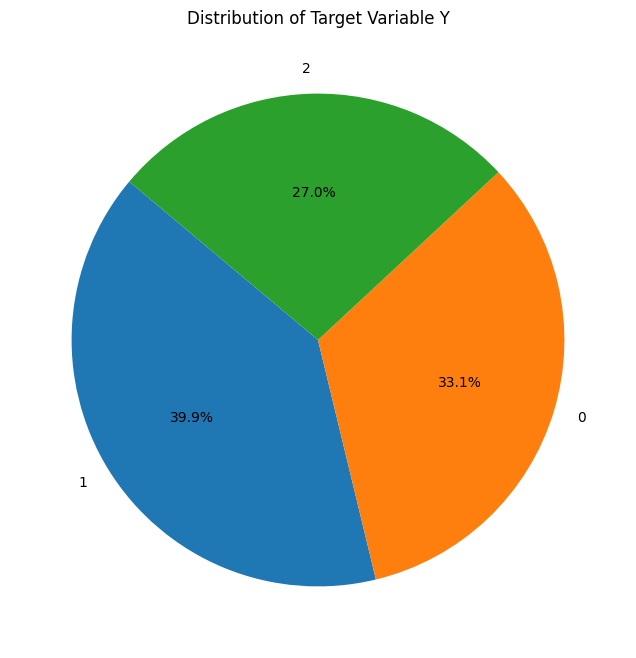

In [69]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

This pie chart shows the proportion of wine classes in the dataset.
Class 1 dominates with 39.9%, followed by class 0 (33.1%) and class 2 (27.0%). The classes are relatively balanced, meaning the dataset is suitable for classification without heavy resampling.

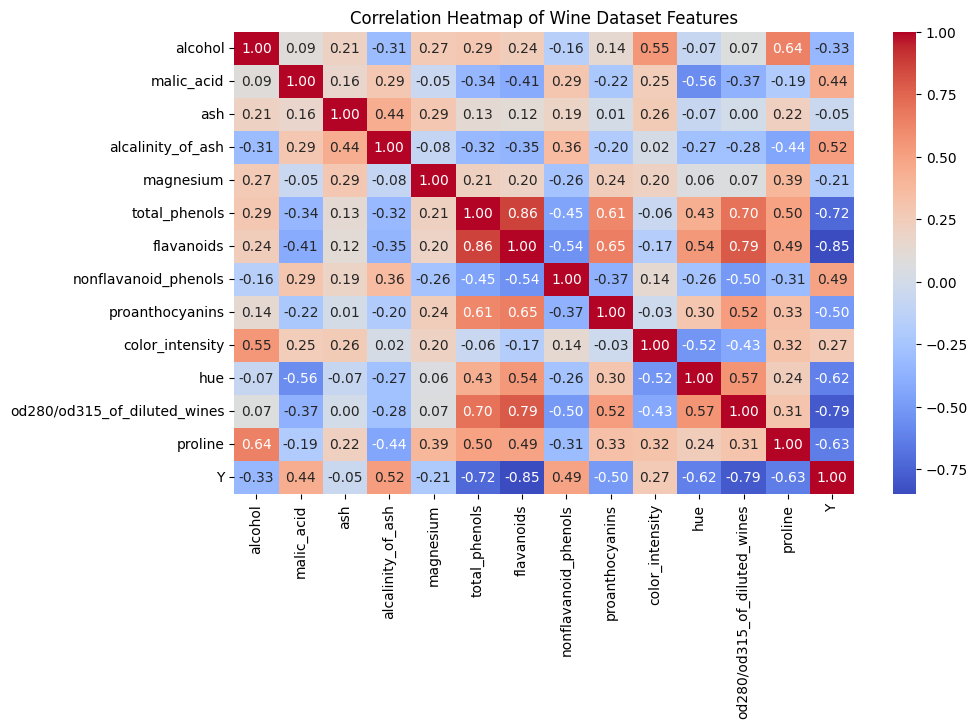

In [70]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wine Dataset Features')
plt.show()

The correlation heatmap provides a comprehensive overview of the linear relationships among all 13 numerical features and the target variable. Warm (red) colors indicate strong positive correlations, while cool (blue) tones show negative ones. Notably, total_phenols and flavanoids exhibit a very strong positive correlation (0.86), meaning wines rich in total phenols also contain higher flavanoid levels, both of which are important for taste and antioxidant properties. Similarly, flavanoids and od280/od315_of_diluted_wines show a strong correlation (0.79), reflecting the optical density’s link to chemical concentration. On the other hand, flavanoids are highly negatively correlated with Y (-0.72), implying that higher flavanoid concentration corresponds to lower class numbers (i.e., class 0 wines). Overall, this heatmap helps identify which features are redundant, strongly associated, or inversely related, offering valuable insights for attribute selection and rule interpretation in the PRISM algorithm.

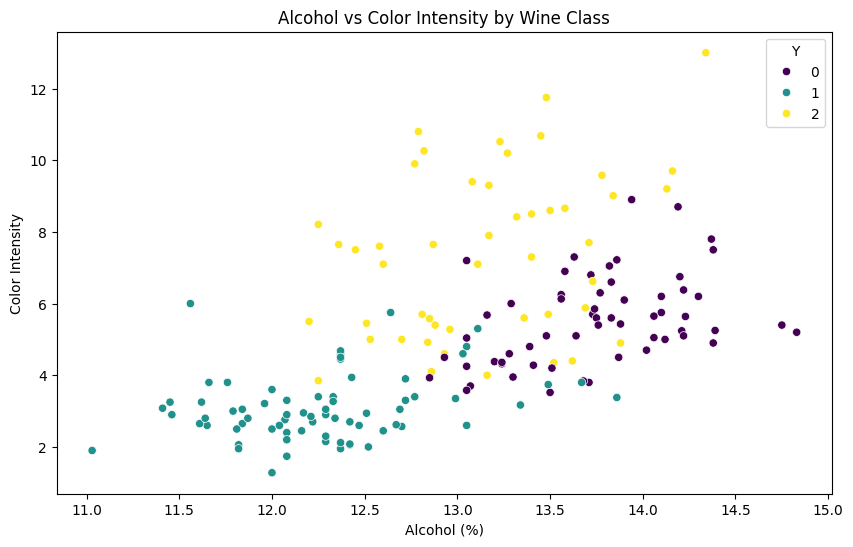

In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='alcohol', y='color_intensity', hue='Y', palette='viridis')
plt.title('Alcohol vs Color Intensity by Wine Class')
plt.xlabel('Alcohol (%)')
plt.ylabel('Color Intensity')
plt.show()

This scatter plot visualizes the relationship between alcohol content (x-axis) and color intensity (y-axis) across the three wine classes. A clear positive trend can be seen—wines with higher alcohol levels tend to have greater color intensity. Class 2 wines (yellow points) are concentrated in the upper-right region, indicating strong color and moderate to high alcohol content. In contrast, class 1 wines (teal points) appear mostly in the lower-left region, reflecting lighter color and lower alcohol concentration. Class 0 wines (purple) are distributed in between but with noticeable clustering toward higher alcohol percentages.

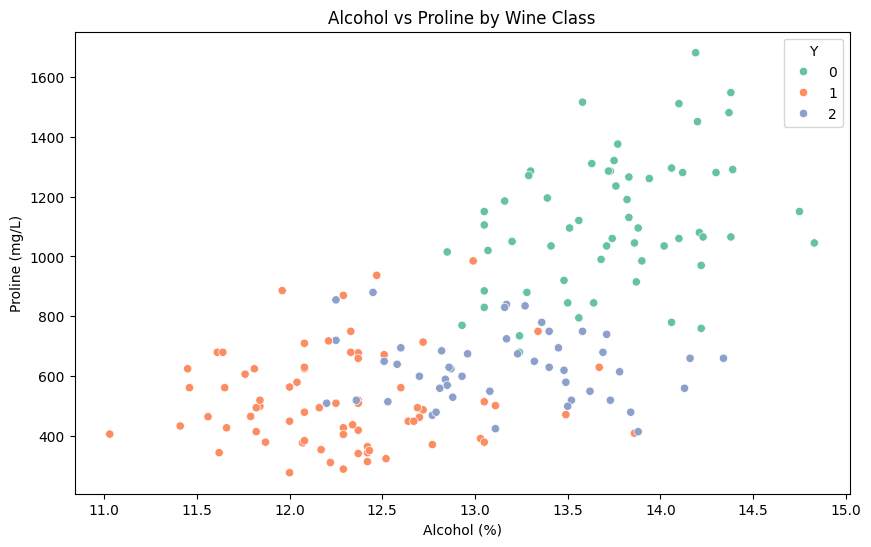

In [72]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='alcohol', y='proline', hue='Y', palette='Set2')
plt.title('Alcohol vs Proline by Wine Class')
plt.xlabel('Alcohol (%)')
plt.ylabel('Proline (mg/L)')
plt.show()

This plot explores the relationship between alcohol percentage and proline concentration, a key amino acid affecting wine aroma and body. The relationship between the two is clearly positive: wines with higher alcohol levels tend to have greater proline content. Class 0 wines (orange) dominate the upper-right region, indicating that they typically possess both strong alcohol and high amino acid concentrations, which may contribute to a fuller and richer flavor profile. Class 1 wines (green) occupy the middle region, while class 2 (blue) are positioned lower, representing lighter wines with lower alcohol and proline. This pattern reinforces the idea that alcohol and proline are highly discriminative variables for identifying class 0 wines.

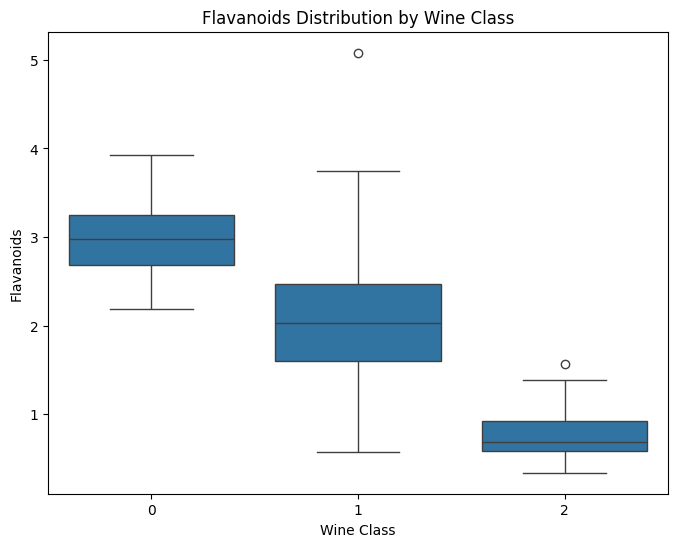

In [73]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Y', y='flavanoids')
plt.title('Flavanoids Distribution by Wine Class')
plt.xlabel('Wine Class')
plt.ylabel('Flavanoids')
plt.show()


This box plot demonstrates the distribution of flavanoid compounds across the three wine classes, providing a clear visual of the median, interquartile range, and outliers. There is a striking difference between the groups: class 0 wines have the highest median flavanoid value (around 3.0), class 1 wines show moderate levels (median around 2.0), and class 2 wines exhibit the lowest flavanoid concentrations (below 1.5). The sharp decline from class 0 to class 2 suggests that flavanoid content is one of the most critical attributes distinguishing between wine types. A few outliers exist, likely due to variations in grape composition or fermentation. The decreasing trend of flavanoids with increasing class number is consistent with the negative correlation seen in the heatmap. This visualization confirms that flavanoids serve as a reliable chemical signature to separate higher-quality wines (class 0) from lower ones (class 2).

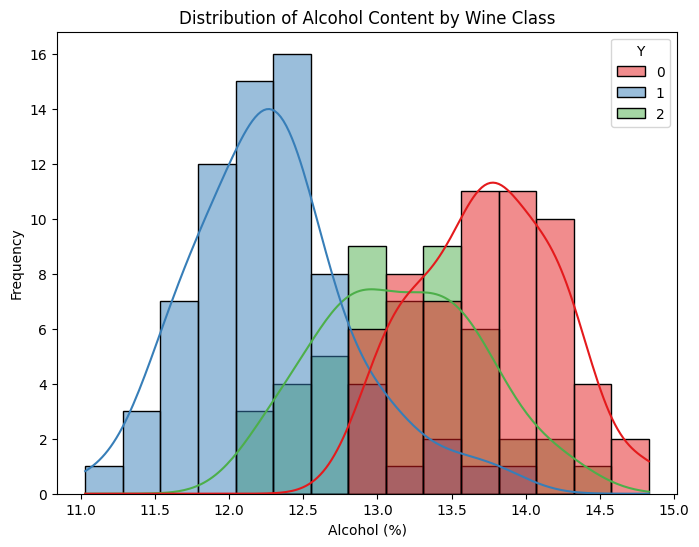

In [74]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='alcohol', hue='Y', kde=True, palette='Set1', bins=15)
plt.title('Distribution of Alcohol Content by Wine Class')
plt.xlabel('Alcohol (%)')
plt.ylabel('Frequency')
plt.show()

This histogram compares the alcohol concentration distributions among the three wine classes. The density curves reveal distinct peaks that clearly separate the groups: class 0 wines cluster around 13.5–14.5% alcohol, class 1 wines around 12–12.5%, and class 2 wines fall mostly in the 13.0–13.5% range. This clear separation suggests that alcohol content is a strong predictor of wine class, reflecting variations in grape sugar levels and fermentation efficiency across cultivators. Class 0 wines, having the highest alcohol concentration, likely originate from grapes with higher sugar content or longer fermentation times, while class 1 wines are comparatively lighter.

# Apply PRISM Algorithm

In [75]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


In [76]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(124), 'Y')


........................................................................
Target: 1
........................................................................
color_intensity = Low
   Support:  the target has value: '1' for 100.000% of the 42 rows matching the rule 
   Coverage: the rule matches: 42 out of 52 rows for target value: '1'. This is:
      80.769% of total rows for target value: '1'
      33.871% of total rows in data

........................................................................
Target: 0
........................................................................
proline = High AND flavanoids = High
   Support:  the target has value: '0' for 100.000% of the 29 rows matching the rule 
   Coverage: the rule matches: 29 out of 34 rows for target value: '0'. This is:
      85.294% of total rows for target value: '0'
      23.387% of total rows in data

........................................................................
Target: 2
.....................................

In this study, the Wine dataset consists of a total of **178 samples**, which are divided into training and testing subsets using a **70:30 ratio**. This means that **124 data points (70%)** are used for training the PRISM classification model, while the remaining **54 data points (30%)** are reserved for testing and evaluating its performance. The 70:30 split is a widely accepted standard in machine learning because it provides enough data for the model to learn patterns effectively while still leaving a sufficient portion unseen for unbiased evaluation. This approach ensures that the model’s predictive performance can be assessed fairly, allowing for a clear understanding of how well the learned rules generalize to new, unseen data.

**Rule 1 — Target: 1**

Rule: `color_intensity = Low`

*If color_intensity is Low → class 1, meaning wines with pale color and lighter appearance tend to belong to class 1.*

Interpretation:
This rule indicates that wines with low color intensity are classified as class 1. In practical terms, these are lighter-colored wines with less pigment concentration, typically produced from grapes with lower anthocyanin levels or shorter fermentation times. Such wines are often softer, smoother, and less bold in flavor compared to darker wines.

Class represented: Class 1 (light-bodied, pale-colored wines).

Strength: The rule has 100% support, meaning every wine that fits this condition belongs to class 1, and 80.77% coverage, capturing the majority of wines within this class. It is a strong, simple, and highly generalizable rule, effectively summarizing the main visual and chemical trait of class 1 wines.

----------------------------------------------------------------

**Rule 2 — Target: 0**

Rule: `proline = High AND flavanoids = High`

*If proline is High and flavanoids are High → class 0, meaning rich, full-bodied wines with strong amino acid and flavonoid content tend to belong to class 0.*

Interpretation:
This rule classifies wines that have high proline (amino acid content) and high flavanoid concentration as class 0. These attributes are chemical markers of wines with richer flavor, deeper structure, and greater antioxidant properties. Such wines are often produced from high-quality grapes with intense chemical composition, leading to a more complex and full-bodied taste profile.

Class represented: Class 0 (strong, full-bodied, high-quality wines).

Strength: The rule shows 100% support, meaning all wines that satisfy this condition are class 0, and 85.29% coverage, indicating that it explains nearly all wines within this class. This makes it a very strong and precise rule, identifying class 0 wines with high reliability.

-------------------------------------------------------------
**Rule 3 — Target: 2 (Rule 1)**

Rule: `flavanoids = Low AND color_intensity = High`

*If flavanoids are Low and color_intensity is High → class 2, meaning dark-colored wines with fewer flavonoid compounds are typically classified as class 2.*

Interpretation:
This rule describes wines that have low flavanoid content but high color intensity, which are classified as class 2. These wines appear dark or deeply colored yet have fewer flavonoid compounds, possibly indicating a distinct fermentation or grape type that emphasizes pigmentation more than chemical richness.

Class represented: Class 2 (dark-colored, low-flavonoid wines).

Strength: The rule achieves 100% support and 60.53% coverage, covering a majority of class-2 wines with perfect accuracy. It is a strong and well-defined rule, representing the main portion of class 2 wines.

--------------------------------------------------------

**Rule 4 — Target: 2 (Rule 2)**

Rule: `flavanoids = Low AND color_intensity = Med`

*If flavanoids are Low and color_intensity is Medium → class 2, meaning wines with moderate color but low flavanoid levels also belong to class 2.*

Interpretation:
This rule captures the remaining class-2 wines characterized by medium color intensity and low flavanoid concentration. It shows that class 2 not only consists of dark wines but also includes moderately colored ones that share the same low-flavonoid chemical signature. This suggests consistency in class-2 wines’ chemical makeup despite slight visual variations.

Class represented: Class 2 (medium-colored, low-flavonoid wines).

Strength: The rule has 100% support and 86.67% coverage of the remaining class-2 samples, making it highly specific and nearly complete for defining this group.

**Summary Insight:**
*   Class 0 wines are defined by high proline and high flavanoid content, representing richer and more complex wines.
*   Class 1 wines are defined by low color intensity, representing lighter, paler wines with softer characteristics.
*   Class 2 wines are characterized by low flavanoids combined with medium to high color intensity, representing darker wines with lower chemical complexity.

## Bin Ranges Result

In [77]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.03,12.45,55
1,alcohol,1,12.45,13.48,62
2,alcohol,2,13.48,14.83,61
3,malic_acid,0,0.74,1.70,63
4,malic_acid,1,1.70,2.89,65
5,malic_acid,2,2.89,5.80,50
6,ash,0,1.36,2.26,53
7,ash,1,2.26,2.48,64
8,ash,2,2.48,3.23,61
9,alcalinity_of_ash,0,10.60,18.50,64


# Model Evaluation

In [78]:
# we use the rest of our data for testing, in this case is 54 rows
y_pred = prism.predict(df.tail(54).drop(columns=['Y']))
f1_score(df.tail(54)['Y'], y_pred, average=None)

array([0.86363636, 0.81818182, 0.9       ])

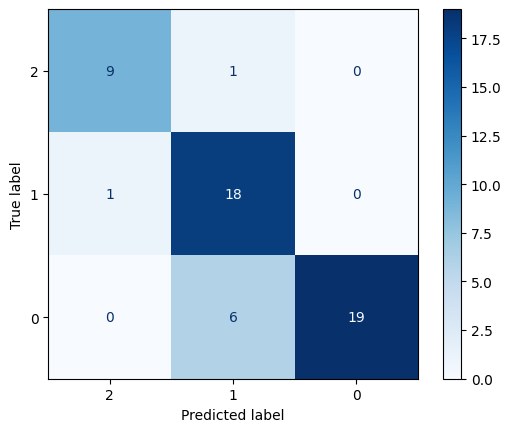

In [79]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(54)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [80]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(54)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86        25
           1       0.72      0.95      0.82        19
           2       0.90      0.90      0.90        10

    accuracy                           0.85        54
   macro avg       0.87      0.87      0.86        54
weighted avg       0.88      0.85      0.85        54



**From the confusion matrix:**
*   Class 0 (True label 0): 19 correctly predicted, 6 misclassified as class 1.
*   Class 1 (True label 1): 18 correctly predicted, 1 misclassified as class 2.
*   Class 2 (True label 2): 9 correctly predicted, 1 misclassified as class 1.

This means the model performs well overall, but there are a few areas of confusion, mainly between class 0 and class 1, where six class-0 wines were mistakenly predicted as class 1. This overlap is reasonable given that both classes can share similar chemical traits, such as moderate alcohol or phenolic content.
<br><br>
**From the classification report:**
*   Class 2 has the best overall performance with high and balanced scores across precision (0.90), recall (0.90), and F1-score (0.90). This means the model identifies class-2 wines accurately and consistently, with few false positives or negatives.
*   Class 0 shows perfect precision (1.00), meaning all wines predicted as class 0 are correct, but recall (0.76) is lower — indicating some class-0 wines were missed and classified as other classes (mostly class 1).
*   Class 1 has the highest recall (0.95) but lower precision (0.72), meaning the model successfully finds most class-1 wines but sometimes incorrectly predicts other classes as class 1.


Conclusion:

The PRISM model achieved an overall accuracy of 85% with a macro average F1-score of 0.86, indicating strong and consistent classification performance across all wine classes. The best-predicted group is class 2, as it demonstrates a well-balanced precision and recall, meaning the model can correctly identify most wines in this class while making very few false predictions. On the other hand, misclassifications mostly occur between class 0 and class 1, where several class-0 wines are incorrectly predicted as class 1. This overlap suggests that both classes share similar chemical characteristics, particularly in alcohol and proline levels, which can make it difficult for rule-based methods to clearly distinguish between them. Such behavior is typical for the PRISM algorithm, as it constructs discrete and interpretable rules that may slightly overlap when feature boundaries between classes are close, resulting in minor but understandable classification confusion.


# Predict New Data Points

In [82]:
# Create new data points for the Wine dataset
# You can change these values to test different scenarios
new_data = {
'alcohol': [14.0, 14.00],
 'malic_acid': [2.0, 2.0],
 'ash': [2.3, 2.2],
 'alcalinity_of_ash': [19.0, 11.0],
 'magnesium': [95.0, 95.0],
 'total_phenols': [2.2, 2.5],
 'flavanoids': [0.14, 0.5],
 'nonflavanoid_phenols': [0.14, 0.5],
 'proanthocyanins': [1.6, 1.5],
 'color_intensity': [7.0, 6.0],
 'hue': [0.7, 0.6],
 'od280/od315_of_diluted_wines': [3.2, 3.0],
 'proline': [550.0, 1]
}

new_wine_df = pd.DataFrame(new_data)

# Predict on the new Wine data using the prism model trained on Wine data
wine_prediction = prism.predict(new_wine_df)
# Assign predictions to a new column in the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Wine Data Points:")
display(new_wine_df)

New Wine Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1.0,2


**Sample 0 → Predicted class 1 (by default class)**

**Which rule(s) applied?**

None. After discretization, this sample’s feature bins did not satisfy any of the learned antecedents:
*   color_intensity = Low (Target 1) → not satisfied
*   proline = High AND flavanoids = High (Target 0) → not satisfied
*   flavanoids = Low AND color_intensity = High (Target 2) → not satisfied
*   flavanoids = Low AND color_intensity = Med (Target 2) → not satisfied

Because no rule fired, PRISM fell through to its default classification.

**Why does PRISM classify it as class 1?**

PRISM (and many rule-based systems) use a default class when no rule matches a case. The default is typically the majority class in the training set (argmax of class prior). In your split, class 1 has the largest frequency among training instances, so the model assigns class 1 to any uncovered case.

*“No learned rule matched the sample’s discretized attributes, so PRISM used the default (majority) class from training → class 1.”*

-------------------------------------------------------
**Sample 1 → Predicted class 2**
* flavanoids = 0.5 → Low (bin 0: 0.34–1.36)   
* color_intensity = 6.0 → High (bin 2: 5.60–13.00)   
* (Others not needed for this rule; e.g., proline = 1400 → High)

**Matched rule (Target 2):**

`flavanoids = Low AND color_intensity = High` → Class 2

**Why PRISM classifies it as class 2?**

PRISM evaluates rules in the learned set and picks the first rule whose antecedents all match the sample’s binned features. Here, the sample simultaneously satisfies Low flavanoids and High color intensity, so it triggers the Target: 2 rule above. Because that rule has 100% support on training data, the prediction is confidently class 2.

**Why other rules didn’t fire?**
*   color_intensity = Low (Target 1) → not satisfied (it’s High).
*   proline = High AND flavanoids = High (Target 0) → not satisfied (flavanoids is Low, not High).
*   flavanoids = Low AND color_intensity = Med (Target 2 alt) → not satisfied (color_intensity is High, not Med).

*“Flavanoids is Low and color_intensity is High, which exactly matches the class-2 rule—so PRISM predicts class 2.”*